In [ ]:
This notebook produces figure 13 of de Sá, Bernardo et al. (2024).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.interpolate import UnivariateSpline
from scipy.stats import mode, linregress

import gc 
import sys
sys.path.append('..')
from src.utils import sample_histogram
from src.sampling import RandomSampling
from src.imf import IGIMF, Star
from src.constants import DATA_PATH, COMPACT_OBJ_DIR_PATH

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [4]:
IGIMF_ZAMS_DIR_PATH = Path(DATA_PATH, '2023_igimf_zams_samples')
ONLYBIN_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_1222_zams_grid')
ALLMULT_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_1212_zams_grid')
ONLYBIN_CANON_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_2122_zams_grid')
ALLMULT_CANON_SAMPLE_DIR_PATH = Path(IGIMF_ZAMS_DIR_PATH, '12x10_2112_zams_grid')

In [5]:
onlybin_sample_paths = list(ONLYBIN_SAMPLE_DIR_PATH.glob('*.parquet'))
allmult_sample_paths = list(ALLMULT_SAMPLE_DIR_PATH.glob('*.parquet'))
onlybin_canon_sample_paths = list(ONLYBIN_CANON_SAMPLE_DIR_PATH.glob('*.parquet'))
allmult_canon_sample_paths = list(ALLMULT_CANON_SAMPLE_DIR_PATH.glob('*.parquet'))
#sample_paths = list(CO_DIR_PATH.glob('*.parquet'))

In [6]:
def normalize_igimf(igimf_x, igimf_y, sample_x, sample_y):
    igimf_spline = UnivariateSpline(igimf_x, igimf_y, k=3)
    sample_spline = UnivariateSpline(sample_x, sample_y, k=3)
    
    igimf_area = igimf_spline.integral(0.8, 150)
    sample_area = sample_spline.integral(0.8, 150)
    
    print(sample_area, igimf_area)
    
    igimf_norm = sample_area/igimf_area
    
    return igimf_norm

In [7]:
def kroupa_imf(m):
    if m < 0.5:
        return 2*m**-1.3
    else:
        return m**-2.3

In [8]:
def gen_mplots(sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 10)):
    m1arr = np.sort(sample_df['Mass_ZAMS1_Found'].to_numpy())
    m2arr = np.sort(sample_df['Mass_ZAMS2_Found'].to_numpy())
    m3arr = np.sort(sample_df['Mass_ZAMS3_Found'].to_numpy())
    m4arr = np.sort(sample_df['Mass_ZAMS4_Found'].to_numpy())
    m5arr = np.sort(sample_df['Mass_ZAMS5_Found'].to_numpy())
    mall_arr = np.sort(np.concatenate((m1arr, m2arr, m3arr, m4arr, m5arr)))
    
    m2arr = m2arr[m2arr >= 0.8]
    m3arr = m3arr[m3arr >= 0.8]
    m4arr = m4arr[m4arr >= 0.8]
    m5arr = m5arr[m5arr >= 0.8]
    mall_arr = mall_arr[mall_arr >= 0.8]
   
    m1h, m1b = np.histogram(m1arr, density=True, bins=bins)
    m2h, m2b = np.histogram(m2arr, density=True, bins=bins)
    m3h, m3b = np.histogram(m3arr, density=True, bins=bins)
    m4h, m4b = np.histogram(m4arr, density=True, bins=bins)
    m5h, m5b = np.histogram(m5arr, density=True, bins=bins)
    mall_h, mall_b = np.histogram(mall_arr, density=True, bins=bins)
    
    m1c = np.array([(m1b0+m1b1)/2 for m1b0, m1b1 in zip(m1b[:-1], m1b[0:])])
    m2c = np.array([(m2b0+m2b1)/2 for m2b0, m2b1 in zip(m2b[:-1], m2b[0:])])
    m3c = np.array([(m3b0+m3b1)/2 for m3b0, m3b1 in zip(m3b[:-1], m3b[0:])])
    m4c = np.array([(m4b0+m4b1)/2 for m4b0, m4b1 in zip(m4b[:-1], m4b[0:])])
    m5c = np.array([(m5b0+m5b1)/2 for m5b0, m5b1 in zip(m5b[:-1], m5b[0:])])
    mall_c = np.array([(mall_b0+mall_b1)/2 for mall_b0, mall_b1 in zip(mall_b[:-1], mall_b[0:])])
    
    mplots = [['$m_1$', m1b, m1c, m1h],
             ['$m_2$', m2b, m2c, m2h],
             ['$m_3$', m3b, m3c, m3h],
             ['$m_4$', m4b, m4c, m4h],
             ['$m_5$', m5b, m5c, m5h],
             ['all $m_i$', mall_b, mall_c, mall_h]]
    
    return mplots

## Redshift plot

#### IMF Grid

In [9]:
onlybin_sample_paths_dict = {}
for path in onlybin_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in onlybin_sample_paths_dict:
        onlybin_sample_paths_dict[z] = []
    onlybin_sample_paths_dict[z].append(path)

In [10]:
allmult_sample_paths_dict = {}
for path in allmult_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in allmult_sample_paths_dict:
        allmult_sample_paths_dict[z] = []
    allmult_sample_paths_dict[z].append(path)

In [11]:
onlybin_canon_sample_paths_dict = {}
for path in onlybin_canon_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in onlybin_canon_sample_paths_dict:
        onlybin_canon_sample_paths_dict[z] = []
    onlybin_canon_sample_paths_dict[z].append(path)

In [12]:
allmult_canon_sample_paths_dict = {}
for path in allmult_canon_sample_paths:
    z = float(path.name.split('_')[0].split('=')[1])
    if z not in allmult_canon_sample_paths_dict:
        allmult_canon_sample_paths_dict[z] = []
    allmult_canon_sample_paths_dict[z].append(path)

In [13]:
for z in onlybin_sample_paths_dict:
    unsorted_paths = onlybin_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    onlybin_sample_paths_dict[z] = sorted_paths

In [14]:
for z in allmult_sample_paths_dict:
    unsorted_paths = allmult_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    allmult_sample_paths_dict[z] = sorted_paths

In [15]:
for z in onlybin_canon_sample_paths_dict:
    unsorted_paths = onlybin_canon_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    onlybin_canon_sample_paths_dict[z] = sorted_paths

In [16]:
for z in allmult_canon_sample_paths_dict:
    unsorted_paths = allmult_canon_sample_paths_dict[z]
    unsorted_sfrs = [float(path.name.split('_')[2].split('=')[1]) for path in unsorted_paths]
    sorted_indexes = np.argsort(unsorted_sfrs)
    sorted_paths = np.array(unsorted_paths)[sorted_indexes]
    allmult_canon_sample_paths_dict[z] = sorted_paths

In [17]:
from matplotlib.lines import Line2D

In [18]:
plot_zs = sorted(list(allmult_canon_sample_paths_dict.keys()))
onlybin_plot_fehs = []
allmult_plot_fehs = []

for z in plot_zs:
        onlybin_sample_paths_ = onlybin_sample_paths_dict[z]   
        allmult_sample_paths_ = allmult_sample_paths_dict[z]   
        for path in onlybin_sample_paths_[:-1]:
                sample_descr = path.name.split('_')[:-3]

                sample_descr_dict = {}
                for attr in sample_descr:
                    key, value = attr.split('=')
                    sample_descr_dict[key] = value
                onlybin_plot_fehs.append(sample_descr_dict['feh'])
        for path in allmult_sample_paths_[:-1]:
                sample_descr = path.name.split('_')[:-3]

                sample_descr_dict = {}
                for attr in sample_descr:
                    key, value = attr.split('=')
                    sample_descr_dict[key] = value
                allmult_plot_fehs.append(sample_descr_dict['feh'])
onlybin_plot_fehs = np.array(onlybin_plot_fehs, np.float32)
allmult_plot_fehs = np.array(allmult_plot_fehs, np.float32)

In [19]:
slope_dict = {}
for z in plot_zs:
    if z not in slope_dict:
        slope_dict[z] = {}
    sample_paths_ = onlybin_sample_paths_dict[z]   

    counter = 0
    for path in sample_paths_:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])  
        sample_df = pd.read_parquet(path, engine='pyarrow')
        slope_dict[z][feh] = {}
        
        mplots = gen_mplots(sample_df, sample_descr_dict)
        counter += 1
        
        for mplot in mplots:
            label, mb, mc, mh = mplot
            mc = np.log10(mc)
            mh = np.log10(mh)
            mc10_i = np.searchsorted(mc, 1)
            slope, *_ = linregress(mc, mh)
            slope1, *_ = linregress(mc[:mc10_i], mh[:mc10_i])
            slope2, *_ = linregress(mc[mc10_i:], mh[mc10_i:])
            slopes = [slope, slope1, slope2]
            print(slopes)
            slope_dict[z][feh][label] = slopes
            #print(f'In {z=}, {feh=}, {label} is best fit by a power-law {slope:.2f}, or {slope1:.2f} up to {10**mc[mc10_i]:.2f} Mo and {slope2:.2f} above.')
        #print('')
        
onlybin_slope_dict = slope_dict

/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-2.0882229264867016, -2.120798120062546, -1.963046601905063]
[-2.2185130219219205, -2.067584975086875, -2.7723795443095613]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-2.104148307754852, -2.1092156443185415, -2.0849224102945985]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.7176604167478118, -2.013629056289484, -1.2581646643030386]
[-1.7727252485367684, -1.7173560138131967, -2.270491044372655]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.7181948317324054, -1.936702770860196, -1.4743626442914044]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6678456704781321, -1.9906075377247316, -1.1747808177975556]
[-1.7153737937055284, -1.6650345505334576, -2.216745806643304]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6662904107067904, -1.9031721855617838, -1.407245975050239]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6450130089932158, -1.9781823980766517, -1.1347746738647093]
[-1.688741275495616, -1.6391679545747933, -2.1914459015906234]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6425108635456156, -1.8859913614245363, -1.3765764740685345]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6268943817968684, -1.9628215732567813, -1.1024465799948977]
[-1.6676234948688118, -1.6187613480209289, -2.1646535644789275]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6238197787048179, -1.8685193733903782, -1.3511045917883422]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6689425183749675, -1.9659830627650972, -1.2360727979983237]
[-1.7329292186265137, -1.6490655296886008, -2.265863791650068]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6713050932703684, -1.8814631441523655, -1.4585984238369905]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6648655223030695, -1.9623626586463125, -1.2427319876870302]
[-1.7304236804823347, -1.6440851266167948, -2.26866726997749]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6676491136815952, -1.8770095089635814, -1.464230725936697]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5767374125649414, -1.9517420855355159, -1.0329727459342861]
[-1.60912690135677, -1.5645836913279956, -2.1070699515634415]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5714967864944862, -1.8405198562904563, -1.2940020702918615]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.608266416826607, -1.932073933587123, -1.1215314828512069]
[-1.659729526831367, -1.586691673884232, -2.1778065052085527]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6077452398840202, -1.836353457381465, -1.365873143320368]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5942140693069544, -1.9204166101948004, -1.1054278245406053]
[-1.6455133277272347, -1.569526724475816, -2.16924252840343]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5935769213837212, -1.8220633919223748, -1.3542585779983478]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-2.0236339425865126, -2.11107124879703, -1.8548337565926505]
[-2.137119787423057, -2.0279353552634887, -2.6572881687460015]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-2.037635886093293, -2.0918052142077093, -1.9861739679564403]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6529810944835497, -1.9769333954987236, -1.1385703182968303]
[-1.699660553393879, -1.6541287832281024, -2.1979062817315227]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.651023385566977, -1.8888278364374096, -1.38032089019185]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.582214689629199, -1.9420162826980287, -1.0176590557791416]
[-1.6172373411806027, -1.5711060249192161, -2.112930524981759]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5771587082264158, -1.8359086590711609, -1.2846854069673856]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6259368101010214, -1.936222776469092, -1.16743416520543]
[-1.6873097815751634, -1.6031783150912846, -2.218411642801894]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6276001794655786, -1.8439834599957103, -1.4040596111909636]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5731334384964935, -1.9202392432369926, -1.0560862955192105]
[-1.621141931273523, -1.5514702564784733, -2.1469173232469854]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5712031717093922, -1.8143101269443187, -1.3165221042304744]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5505677683775334, -1.9023345185206202, -1.0118560051392438]
[-1.5957328422687789, -1.5268011200742644, -2.118544093833505]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5480023605064217, -1.7932370938733093, -1.2843198426409683]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.528309211255342, -1.8896759530142269, -0.9830371721932942]
[-1.571025014315768, -1.4999841566610184, -2.092732021140016]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5251012117361544, -1.7743631414705716, -1.2602432807711603]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5019884677141415, -1.8892460308018688, -0.9379591404019842]
[-1.53873959701823, -1.473987820681684, -2.0592749466452167]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4971046040910976, -1.762841576654492, -1.2247488678386345]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4841077234798872, -1.8767597477689442, -0.9149679983830481]
[-1.5209932889057998, -1.4528842052583306, -2.0465707653761838]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4790241033367724, -1.7461815403935803, -1.2074489382378453]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4507820636490327, -1.8467788890638763, -0.8544595345823445]
[-1.484488236938626, -1.4116580497007403, -2.009638467635488]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4445148199223992, -1.710258149905705, -1.1626845309645084]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.9799074169991406, -2.0941340168166844, -1.7700243249184975]
[-2.0877346047926797, -1.9951798369434484, -2.606956942590686]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.9924593594224789, -2.0709200071190024, -1.9104479821584242]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.642547319487972, -1.9653468010779922, -1.1650404894333932]
[-1.6989560994002495, -1.638048779074754, -2.216024019249416]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6428819063478823, -1.8742892375515485, -1.4013244369733893]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5804749978945463, -1.9358249430294465, -1.0667483257852823]
[-1.6277351189900557, -1.5666694888295898, -2.1478374476351543]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.578368353951885, -1.8285722071309782, -1.3231049033772262]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5421330445123835, -1.9104717537413332, -1.0003148323676394]
[-1.5833700878343846, -1.523623233767457, -2.100714679948637]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5386513685967913, -1.7955929672197002, -1.2734032665899935]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.507179342412962, -1.8829634629533316, -0.9329310290626374]
[-1.5440344513973783, -1.481881468315568, -2.057694439300741]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5022416158708523, -1.7616395074163345, -1.2214442878263074]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.486785296210724, -1.8690703975541048, -0.9047383007510809]
[-1.5233546727705745, -1.4575535558920105, -2.041759142652937]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4815799554676086, -1.7428802157820094, -1.2007170097702702]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.463125648895317, -1.856880445233881, -0.8669821662979218]
[-1.4959369548849546, -1.428690703695627, -2.014738284897208]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4567523818769645, -1.7228553080999955, -1.171783411944907]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4386477928992198, -1.8380248984384573, -0.8272649445515395]
[-1.4705180712548724, -1.4025152639267795, -1.9935327566788896]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4315727255810167, -1.6999510908252808, -1.1425335155727467]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4117836902621463, -1.8252708631179824, -0.7878918652886314]
[-1.4410071439826182, -1.3725019927803772, -1.965583259506254]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4038012954266823, -1.6785100749822626, -1.113071699790005]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3720130968049038, -1.8096838185362696, -0.7294315942102586]
[-1.3949839556593937, -1.3311816576371247, -1.9156520670850699]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.362286606033868, -1.6490531159431825, -1.0688186234839854]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.9553100794941516, -2.0523654689131585, -1.715250438646145]
[-2.060405582457951, -1.964101952296967, -2.562150883381047]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.9675218070825162, -2.031786561993555, -1.8617523949815198]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.6285873932456107, -1.9337341935424222, -1.1488022455381681]
[-1.6885395005379271, -1.6175221804590934, -2.2089920986332285]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.6296177392094482, -1.8457725523447892, -1.3892608151321513]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5460335485194034, -1.8954931522742697, -0.9920334385318308]
[-1.5881463317903972, -1.5291166778181349, -2.0978567045437546]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.542673116774411, -1.7880380378987626, -1.267872928872737]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5032562266567597, -1.8772644555644709, -0.9245501919524267]
[-1.5411628020485366, -1.4779241410942126, -2.0568537187020057]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4983637002440224, -1.7560215295947623, -1.2156945440240823]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4741821818052734, -1.8581479842161022, -0.8813437895646842]
[-1.5087696830093211, -1.4426165840726872, -2.0250025823399183]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4682529376868039, -1.7295571204042561, -1.1821435165927936]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4471933478153156, -1.844400045588384, -0.8360323894255094]
[-1.47807528116331, -1.4128925742050906, -1.9947537620088631]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4399743728473535, -1.708039003518446, -1.147731579387794]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4214929112081802, -1.8409482999409204, -0.8017276544363973]
[-1.4492037114339877, -1.3871106068315227, -1.9692414000174823]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4132783246206833, -1.6936138932223077, -1.1221495435151103]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3952439572347854, -1.8273061313347898, -0.7593204149185038]
[-1.4198803347086737, -1.3586905425248308, -1.9419987653980926]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3859292961872485, -1.6723790751575944, -1.0913751939401857]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3668109523611975, -1.8129499134080198, -0.7129314117781358]
[-1.3867536547622037, -1.3267317134033993, -1.9039531255780415]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3561467622046688, -1.6483860187716481, -1.0566254425779233]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3243759111794662, -1.780390697401426, -0.6458049911094064]
[-1.3408247183985256, -1.2740425509449322, -1.85562626301171]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3123936228992086, -1.604754031082888, -1.0070861363240333]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.9359204315030172, -2.058367647612497, -1.6910815443217166]
[-2.0419788271957393, -1.9520317488150714, -2.5532959153890507]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.9480000526569359, -2.032928534051981, -1.840300819447644]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5840196675939857, -1.9162337980693067, -1.0464929008860446]
[-1.6318883922041563, -1.5742222718310248, -2.1415064690196015]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.581799356927601, -1.817832674020705, -1.3089972031783428]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5141758549408901, -1.8954631136932663, -0.9372159627809254]
[-1.5494387004186492, -1.4996804436463933, -2.054759236910506]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5088266170468911, -1.7746092374326252, -1.2234648497616163]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4790746986074832, -1.8770007287019308, -0.8833110012685785]
[-1.5117306517139197, -1.4544701956705324, -2.0275336371292267]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.472579642517104, -1.7452979413645267, -1.1838040052307905]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4459330340524952, -1.8580684705036556, -0.8350551250441398]
[-1.473997187468908, -1.4166931978595945, -1.9888915607933455]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4380674801261633, -1.7170231900832444, -1.146359885890533]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.41717441413085, -1.8427599334010305, -0.789343710561981]
[-1.4425696478764203, -1.3841799869946179, -1.9590310923582037]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4083771904652984, -1.693055552425097, -1.1130935950576104]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.38910448295712, -1.8153554980863615, -0.7461231902996316]
[-1.4133152220075629, -1.3499242000844391, -1.9300268039336252]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3797479542557056, -1.6617864424508388, -1.0810844249275144]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3624179489319925, -1.8011372035930777, -0.7021478618125646]
[-1.3826050875783582, -1.3196806134621892, -1.895835170298895]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3518130086767917, -1.6386519223532432, -1.0484585510038917]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3316397559331643, -1.7842473693231473, -0.6591479115622535]
[-1.349313807202551, -1.2831881673321681, -1.8660246903911553]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3199303752490525, -1.6112854329679385, -1.0163394298040092]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2867587296902507, -1.758202009063066, -0.5821211703922132]
[-1.2983242912686255, -1.2301193482039063, -1.8080914782476938]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.27313898675619, -1.5697101280344221, -0.9616019844967151]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.9179839453554917, -2.054102269790824, -1.6383258423762392]
[-2.0253465156701322, -1.939644407398733, -2.543146535321612]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.9294110741460317, -2.0261847017740893, -1.7945170999015403]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5546842925910298, -1.8994343238374816, -1.0005688972833136]
[-1.5979735589964343, -1.5449294883446743, -2.099094530782954]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5512947663250578, -1.7952477711065478, -1.2704062284255389]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4881844330537062, -1.8689919325338278, -0.8941876093337272]
[-1.5210879125242875, -1.4661507267444711, -2.0190526362663994]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4821411274143381, -1.744932547501609, -1.1883349679989132]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4471212181323463, -1.8505754339337097, -0.8274322529750892]
[-1.4742590123998904, -1.4172198049816078, -1.9761041130625538]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4392655943223212, -1.7123763682612634, -1.1395802962937658]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4134636713212634, -1.8329967702700485, -0.7760254093009314]
[-1.43607363119764, -1.379976441846313, -1.9392055675214335]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4041303189306606, -1.685026256371687, -1.100940208509318]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3815709210502345, -1.8134201515560429, -0.7293497413331013]
[-1.4013101329529065, -1.3397222115635552, -1.9062436615104197]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3712347615469873, -1.6554915569047322, -1.0662234074683477]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3537274890689697, -1.7914852949344051, -0.6868721802759625]
[-1.3712180957624873, -1.3077694752683722, -1.8732862526184122]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3427382213594026, -1.6274839864161745, -1.0355970129304783]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3250240183464324, -1.7776131880413029, -0.6409902984061931]
[-1.3382418087146695, -1.2747931577337324, -1.8414186584056833]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3126384246864922, -1.6033597334055225, -1.0035756696767213]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2918516290324626, -1.7599756954084274, -0.5901813260628481]
[-1.3014496965348281, -1.2362802241565451, -1.8039794102427973]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2780787466521502, -1.5738131743564683, -0.966084364906583]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2442352834204236, -1.745037986619882, -0.5211324212546599]
[-1.247892867924863, -1.1812416872548954, -1.7542964282750344]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2281282981473518, -1.535976644023209, -0.9161476130363929]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.8958269400793262, -2.0060179078423, -1.6013142051225209]
[-1.9938232035111556, -1.907421118070219, -2.4614449564377496]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.906980415638892, -1.9823482987623202, -1.757791612571443]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5322680356190517, -1.884442698094119, -0.9503597428635787]
[-1.5721149421315208, -1.5217759146201097, -2.071085342019864]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5276217994550145, -1.7755597994650443, -1.2327488414057626]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4624657776648233, -1.8526373764133743, -0.8464196929741183]
[-1.4935680695809908, -1.441158095493809, -1.9976501712630845]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.455265535394331, -1.7233892579694083, -1.1537842557378457]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4193252899155557, -1.8281601774916305, -0.7774641940588044]
[-1.442678555329906, -1.3862536654590583, -1.9407334578329578]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4101288097085165, -1.6850010117721428, -1.1017421151791584]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3837206771171746, -1.8104936546404853, -0.7251865625341263]
[-1.402789964634816, -1.345321189590674, -1.9009705347904708]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.373244552118486, -1.6552252416816444, -1.0633635372032613]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3523889907380409, -1.8020260588826418, -0.6785367455110186]
[-1.3663934472230306, -1.3135710455547025, -1.866619671054005]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3402402198455592, -1.6345222293589343, -1.0294233314036756]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3203566567882852, -1.788224380638339, -0.623921993775593]
[-1.329140509013201, -1.2748958677168047, -1.82619640339401]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.30660914126151, -1.6073307167932511, -0.990468429469672]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.28942961337911, -1.7728268675284118, -0.5786607969311643]
[-1.2955539270730292, -1.238360055894121, -1.7967105123193459]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2743608725251119, -1.5801769825249405, -0.9572017439758339]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.254372784446329, -1.7464012501910142, -0.5214100940716406]
[-1.2574112730571692, -1.193743715867555, -1.757262828605812]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.238005529726532, -1.5433202926145462, -0.9163928191243152]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2034695529937083, -1.7205862243336474, -0.4521917219495946]
[-1.2026285791743117, -1.1333930877453724, -1.7060299929086737]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.185406706179037, -1.495717288315904, -0.8677798013248241]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.892054192112841, -2.0048300309909806, -1.5829123090099848]
[-1.9937973269723575, -1.908445172736898, -2.4852001491616655]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.9032097384575175, -1.9814302199861025, -1.7471182520666966]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5345264955197033, -1.8971965939015891, -0.9674770881599416]
[-1.5742668912798103, -1.5302391450291044, -2.069244992212972]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.530050136821546, -1.7857077493960622, -1.242359211390543]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4596045531406847, -1.8659907692336537, -0.8415222198146299]
[-1.4864426185788164, -1.4408613971597655, -1.9809243918793225]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4515938509800579, -1.7299541530698974, -1.147745183638721]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4107435620875324, -1.8409064644075968, -0.7640772974386842]
[-1.429982290657863, -1.3836092222267407, -1.9277702166932091]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4004476455891177, -1.6899397422279618, -1.091627775136549]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3723118916084298, -1.8192474441799726, -0.6991818422164842]
[-1.3856116937921052, -1.3389823221828323, -1.880892703031353]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3601998474925416, -1.6566713810503029, -1.0447781679878885]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3385492697613095, -1.7904038338597852, -0.6462163818438339]
[-1.3495426370762305, -1.2961709400687917, -1.842156860700863]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3255353502344116, -1.619521060068802, -1.0060728081435575]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3073924487684596, -1.771446021042884, -0.5982329620620941]
[-1.3157953478627353, -1.259798832711887, -1.8125942863356284]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.293179617221825, -1.591040886151707, -0.9724205096222412]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2743849811503294, -1.7596874876338964, -0.5465855199437619]
[-1.2777528051063833, -1.2198076499298682, -1.7754825405604475]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2582446085936088, -1.5638533250413593, -0.9342597166715282]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2360166923688074, -1.7413613743343366, -0.4890417889802935]
[-1.2359562476068553, -1.1744016409228597, -1.7350034253208957]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2184636248630025, -1.5291592270696637, -0.894329549309616]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.1826203475931505, -1.710652814887528, -0.4112275028629005]
[-1.1773263125239197, -1.11074739730828, -1.6751893214269375]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.1629098620447533, -1.4771858288832656, -0.8389005753182185]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.8820383205928768, -2.020958824182701, -1.598009745393088]
[-1.9795643878011953, -1.906165497456453, -2.446742507908808]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.8931925529712736, -1.9922088575350902, -1.751785979211945]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5537207709176164, -1.8849160001536134, -0.9880571031839637]
[-1.5991163820150136, -1.5532529389956151, -2.0938967108971074]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5505641249289905, -1.7868457471623522, -1.2611605132110169]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4730105822565553, -1.853825693787788, -0.8435267134216616]
[-1.5041426153913957, -1.4610368214423795, -2.002882150453689]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4655231200408207, -1.730295721961863, -1.1537869529699574]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4167647339817369, -1.8355811534748667, -0.764378252947364]
[-1.437462076180776, -1.3893280053685833, -1.9283326045895988]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.406781806890913, -1.6885565680494017, -1.0912835979072417]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3727215252870135, -1.8116651746143084, -0.6869322840820166]
[-1.3858003039301219, -1.3401033420950619, -1.874460993564516]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3602905731487767, -1.6518653337832379, -1.0353825601618163]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3324305703606796, -1.786138345134901, -0.62884039000184]
[-1.3416738245437152, -1.289857634593613, -1.8323847100142154]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3186594362298971, -1.6141311106766532, -0.9932983559192136]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2967069622046126, -1.7675931459980858, -0.5765978541145921]
[-1.3030075385191657, -1.2480444120525414, -1.7970301469552614]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2816583510823554, -1.5823264484798807, -0.9562330746937536]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.258915143063802, -1.7519548706515975, -0.5157703579464468]
[-1.2589378508780311, -1.2035343821135405, -1.750158381182857]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.241653475137329, -1.5504671388919062, -0.911637674341335]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.217924340699286, -1.732425034280912, -0.44934720938000394]
[-1.212525475505324, -1.1548371694170825, -1.702325352458141]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.19852527178984, -1.5134056957852935, -0.8648401434491664]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.1586252289896062, -1.7075281052652238, -0.35633470178957527]
[-1.144598802866662, -1.0876595458843663, -1.634261773356198]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.1357322612886867, -1.4612476019097052, -0.8008929557834716]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.8715878545191442, -2.004527830544278, -1.5854807158674622]
[-1.9774345905642123, -1.8989332007448043, -2.473737879285098]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.8835338092553633, -1.9777299542493203, -1.744504865883344]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5977706926184567, -1.8964201933543605, -1.062612992465576]
[-1.6517039386031402, -1.604691308943498, -2.137807910447033]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5972454661813233, -1.8118596097122135, -1.3194393117305927]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5083479485379303, -1.8597463317945402, -0.8864926823870342]
[-1.543044096307444, -1.50694005960032, -2.028547499284314]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5020784899279591, -1.7510478773982536, -1.1861288904441296]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.44743419432421, -1.8462119794830605, -0.7990590901535171]
[-1.4712934925541228, -1.4417408287602593, -1.9558687358793865]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.438129353637822, -1.7147024322260989, -1.1183011717219429]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3945766713918608, -1.8254990554496844, -0.72116178053705]
[-1.4087949601764147, -1.3762904170616275, -1.8925567109488322]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3825492851820984, -1.6745126562525636, -1.0595020879676196]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.346191079953085, -1.8033508665009472, -0.6361947334706411]
[-1.3551375675184263, -1.3168959643616729, -1.8450805713643164]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3319465027203785, -1.6341067390554633, -1.0000783332699685]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2985551577202243, -1.7710537979990082, -0.5619496033252356]
[-1.3019920394278928, -1.2559371446515193, -1.7879239151183746]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2825246491111746, -1.5866870634228512, -0.9465735225770345]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2518492518711644, -1.7491881152563864, -0.4858798976510168]
[-1.2465246431152583, -1.2013033834599012, -1.7239046598755359]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2330233003736533, -1.5461692197061168, -0.8910217850338302]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.1998513761489331, -1.7232241450401857, -0.4134831354555855]
[-1.1903890743948182, -1.1382227281022095, -1.673518368765067]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.1789715702291912, -1.4977104761196176, -0.839873584188445]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.1279099809551034, -1.6957175569968312, -0.29901188887388586]
[-1.1073351586998366, -1.0504551851009727, -1.5848418521716463]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.1027744075508563, -1.4330954974140715, -0.7593042913799856]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.8477894554591539, -1.971297558768049, -1.539256447996539]
[-1.9495943247300598, -1.8812244866342764, -2.4248300917330563]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.8595302264241627, -1.9481941208679858, -1.7044853663663055]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5905524423028883, -1.8954398173706908, -1.0539558035074112]
[-1.6435904175996603, -1.6076363390755495, -2.122685932975562]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5897783316162646, -1.8099884831717605, -1.3097550522495751]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5060789357483637, -1.848896036620574, -0.8846543788862125]
[-1.5424124236779098, -1.5120997126982434, -2.017858736125811]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5002116676766808, -1.7445234115729311, -1.18192565820776]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4620856283109334, -1.8269505751193509, -0.809913996235989]
[-1.4914654358404158, -1.4579099504609259, -1.9679436036663438]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4541606498021884, -1.7089383320437355, -1.127258970009945]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4195949252133655, -1.8157839722084328, -0.7378608946178495]
[-1.4402740422146905, -1.4088659431154198, -1.9156016005051975]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4090423501221565, -1.6809905531398779, -1.0736159800884066]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3769043278579263, -1.7951083861244372, -0.6720266936693489]
[-1.3889415356548505, -1.360767896124629, -1.858588335633149]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3638969681186848, -1.6476584832233363, -1.0240568053313484]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3305763524850338, -1.7927100737991264, -0.5956945419857168]
[-1.3353806529166155, -1.30701734612555, -1.812121136161484]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.314751060909937, -1.6202654235831582, -0.9692187054487804]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.276023508450234, -1.7584256333241182, -0.4963923887614445]
[-1.2706339245630747, -1.23887812954636, -1.7343971640238667]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2568759613409033, -1.567587164635556, -0.89758376869534]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2109421684379025, -1.730952085233788, -0.3996122437444194]
[-1.195130415579459, -1.1618114762349032, -1.6545612848691944]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.188082804678522, -1.5113902750643318, -0.8277331075904212]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.1156869640940787, -1.6925830344935124, -0.24027479859579262]
[-1.0856614098777182, -1.0469873876565479, -1.5424935154574695]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.0868314911555745, -1.4254767662148486, -0.7199338136518462]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.772314479977431, -1.8692497748215253, -1.4268137988317344]
[-1.8880063743974798, -1.8054634102487308, -2.3690688284563226]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.7867263828646092, -1.851138518272467, -1.609468603418451]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.5222102022762272, -1.8038271396103958, -0.9181011031564514]
[-1.5742737239348954, -1.544043373164597, -2.0347075662396956]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.5202831489297863, -1.722536294742234, -1.204448362796675]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.4670637587810003, -1.8084709075293899, -0.8425771893938816]
[-1.5066244009574516, -1.4831907931355717, -1.9744669401972579]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4618378117472346, -1.7014911217015138, -1.1472194810051297]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.417572782631059, -1.771857503104718, -0.7309678081369869]
[-1.447515093862219, -1.422153611997787, -1.9089298905688428]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.4089907944849405, -1.654613371627993, -1.0663579180787432]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3802130138820237, -1.7604640341898834, -0.6521777665210134]
[-1.3987058353318076, -1.3801877099434532, -1.8494205354271873]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.368114025049184, -1.6293864931236657, -1.0076914889489883]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3450555660528196, -1.7583148027130686, -0.5955327362717863]
[-1.3555805274321726, -1.3391547134687871, -1.8014548526420426]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.3307763568955948, -1.6091678495180164, -0.9662709766691426]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.3156762500379982, -1.7442344572320274, -0.5462816946124153]
[-1.3207438572193073, -1.302859048778788, -1.7655106911720155]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2994832829804595, -1.5838937089691283, -0.9311125844485891]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.28301841415807, -1.7344427646654104, -0.48928725379475485]
[-1.2817747589441693, -1.26408419099518, -1.7250888130941513]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2645380834882862, -1.5594536129812782, -0.8907646693665259]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[-1.2394537362611204, -1.7246158357584103, -0.4088351623989897]
[-1.227097073939881, -1.2117396802546487, -1.6627718269884804]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.2172437527617435, -1.5270470064205797, -0.8342919586829189]
[-1.1658467725454686, -1.7170016417460587, -0.28144815410309715]
[-1.1362057781888133, -1.1270994128598046, -1.5681943315824372]
[nan, nan, nan]
[nan, nan, nan]
[nan, nan, nan]
[-1.1371493516161393, -1.4762898591279938, -0.7459621521437038]


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [20]:
slope_dict = {}
for z in plot_zs:
    if z not in slope_dict:
        slope_dict[z] = {}
    sample_paths_ = onlybin_canon_sample_paths_dict[z]   

    counter = 0
    for path in sample_paths_:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])  
        sample_df = pd.read_parquet(path, engine='pyarrow')
        slope_dict[z][feh] = {}
        
        mplots = gen_mplots(sample_df, sample_descr_dict)
        counter += 1
        
        for mplot in mplots:
            label, mb, mc, mh = mplot
            mc = np.log10(mc)
            mh = np.log10(mh)
            mc10_i = np.searchsorted(mc, 1)
            slope, *_ = linregress(mc, mh)
            slope1, *_ = linregress(mc[:mc10_i], mh[:mc10_i])
            slope2, *_ = linregress(mc[mc10_i:], mh[mc10_i:])
            slopes = [slope, slope1, slope2]
            slope_dict[z][feh][label] = slopes
            #print(f'In {z=}, {feh=}, {label} is best fit by a power-law {slope:.2f}, or {slope1:.2f} up to {10**mc[mc10_i]:.2f} Mo and {slope2:.2f} above.')
        #print('')
        
onlybin_canon_slope_dict = slope_dict

/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/numpy/lib/histograms.

In [21]:
slope_dict = {}
for z in plot_zs:
    if z not in slope_dict:
        slope_dict[z] = {}
    sample_paths_ = allmult_sample_paths_dict[z]   

    counter = 0
    for path in sample_paths_:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])  
        sample_df = pd.read_parquet(path, engine='pyarrow')
        slope_dict[z][feh] = {}
        
        mplots = gen_mplots(sample_df, sample_descr_dict)
        counter += 1
        
        for mplot in mplots:
            label, mb, mc, mh = mplot
            mc = np.log10(mc)
            mh = np.log10(mh)
            mc10_i = np.searchsorted(mc, 1)
            slope, *_ = linregress(mc, mh)
            slope1, *_ = linregress(mc[:mc10_i], mh[:mc10_i])
            slope2, *_ = linregress(mc[mc10_i:], mh[mc10_i:])
            slopes = [slope, slope1, slope2]
            slope_dict[z][feh][label] = slopes
            #print(f'In {z=}, {feh=}, {label} is best fit by a power-law {slope:.2f}, or {slope1:.2f} up to {10**mc[mc10_i]:.2f} Mo and {slope2:.2f} above.')
        #print('')
        
allmult_slope_dict = slope_dict

In [22]:
slope_dict = {}
for z in plot_zs:
    if z not in slope_dict:
        slope_dict[z] = {}
    sample_paths_ = allmult_canon_sample_paths_dict[z]   

    counter = 0
    for path in sample_paths_:
        sample_descr = path.name.split('_')[:-3]

        sample_descr_dict = {}
        for attr in sample_descr:
            key, value = attr.split('=')
            sample_descr_dict[key] = value
            
        feh = np.float32(sample_descr_dict['feh'])  
        sample_df = pd.read_parquet(path, engine='pyarrow')
        slope_dict[z][feh] = {}
        
        mplots = gen_mplots(sample_df, sample_descr_dict)
        counter += 1
        
        for mplot in mplots:
            label, mb, mc, mh = mplot
            mc = np.log10(mc)
            mh = np.log10(mh)
            mc10_i = np.searchsorted(mc, 1)
            slope, *_ = linregress(mc, mh)
            slope1, *_ = linregress(mc[:mc10_i], mh[:mc10_i])
            slope2, *_ = linregress(mc[mc10_i:], mh[mc10_i:])
            slopes = [slope, slope1, slope2]
            slope_dict[z][feh][label] = slopes
            #print(f'In {z=}, {feh=}, {label} is best fit by a power-law {slope:.2f}, or {slope1:.2f} up to {10**mc[mc10_i]:.2f} Mo and {slope2:.2f} above.')
        #print('')
        
allmult_canon_slope_dict = slope_dict

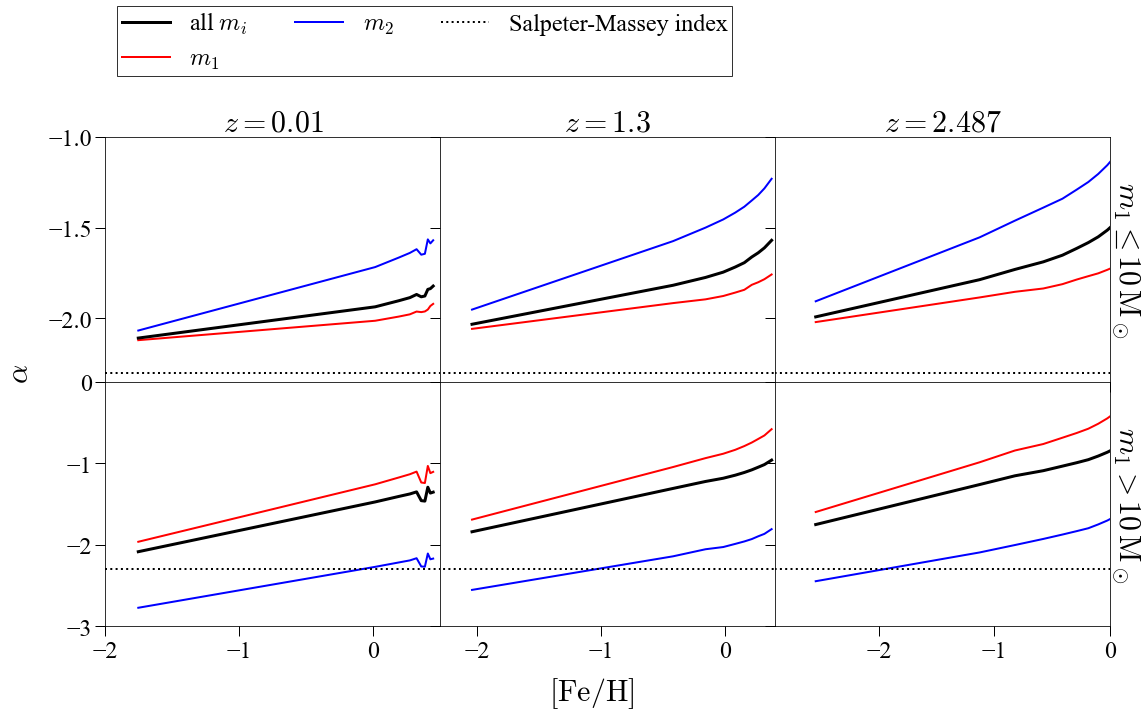

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = list(onlybin_slope_dict.keys())[::4]
for z, ax in zip(plot_zs, axes[0]):
    z_dict = onlybin_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1]):
    z_dict = onlybin_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)

    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-2.35, -1)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-3, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2, 0.5)
axes[0,1].set_xlim(-2.3, 0.4)
axes[0,2].set_xlim(-2.9, 0)
    
#axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='k', lw=3, label='all $m_i$'),
           Line2D([2], [1], color='r', lw=2, label='$m_1$'),
           Line2D([2], [1], color='b', lw=2, label='$m_2$'),
           Line2D([2], [1], color='k', lw=2, ls=':', label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

for z, ax in zip(plot_zs, axes[0]):
    ax.text(0.5, 1, f'$z={z}$', ha='center', va='bottom', transform=ax.transAxes)

axes[0,2].text(1, 0.5, r'$m_1\leq10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[0,2].transAxes)
axes[1,2].text(1, 0.5, r'$m_1>10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[1,2].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

plt.savefig(FIGURE_FOLDER/f'imf_exponent_onlybin_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_exponent_onlybin_1e6.png', bbox_inches='tight')

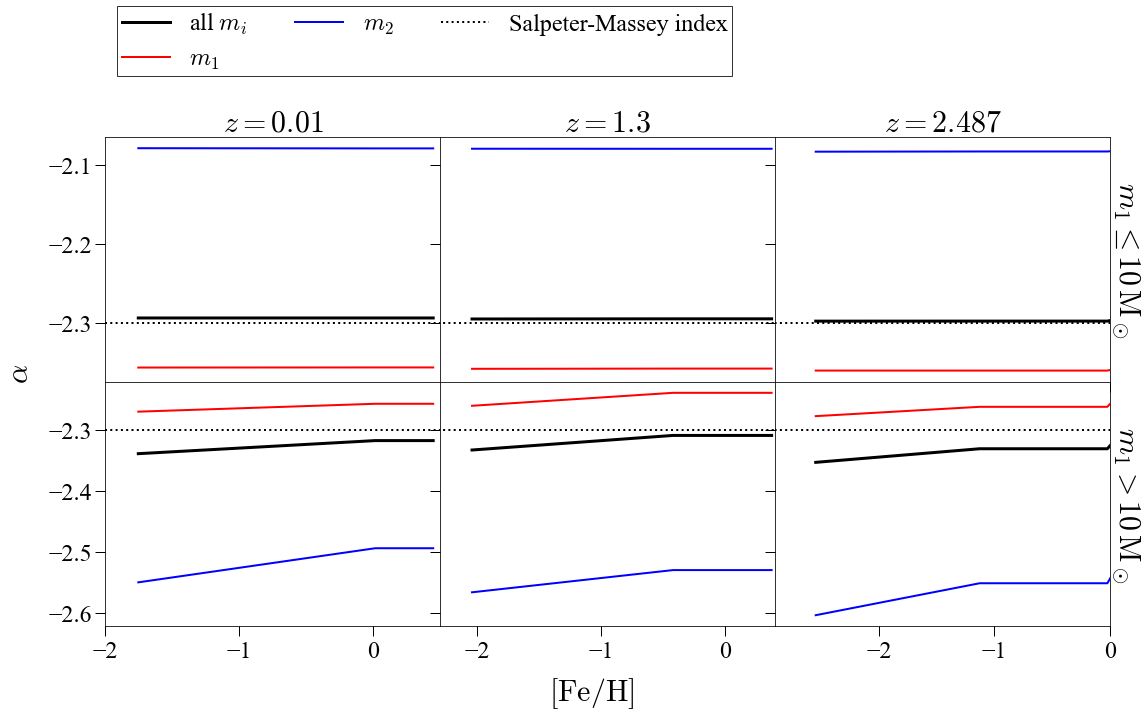

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = list(onlybin_slope_dict.keys())[::4]
for z, ax in zip(plot_zs, axes[0]):
    z_dict = onlybin_canon_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1]):
    z_dict = onlybin_canon_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)

    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    #ax.set_ylim(-2.35, -1)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    #ax.set_ylim(-3, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2, 0.5)
axes[0,1].set_xlim(-2.3, 0.4)
axes[0,2].set_xlim(-2.9, 0)
    
#axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='k', lw=3, label='all $m_i$'),
           Line2D([2], [1], color='r', lw=2, label='$m_1$'),
           Line2D([2], [1], color='b', lw=2, label='$m_2$'),
           Line2D([2], [1], color='k', lw=2, ls=':', label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

for z, ax in zip(plot_zs, axes[0]):
    ax.text(0.5, 1, f'$z={z}$', ha='center', va='bottom', transform=ax.transAxes)

axes[0,2].text(1, 0.5, r'$m_1\leq10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[0,2].transAxes)
axes[1,2].text(1, 0.5, r'$m_1>10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[1,2].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

plt.savefig(FIGURE_FOLDER/f'imf_exponent_canon_onlybin_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_exponent_canon_onlybin_1e6.png', bbox_inches='tight')

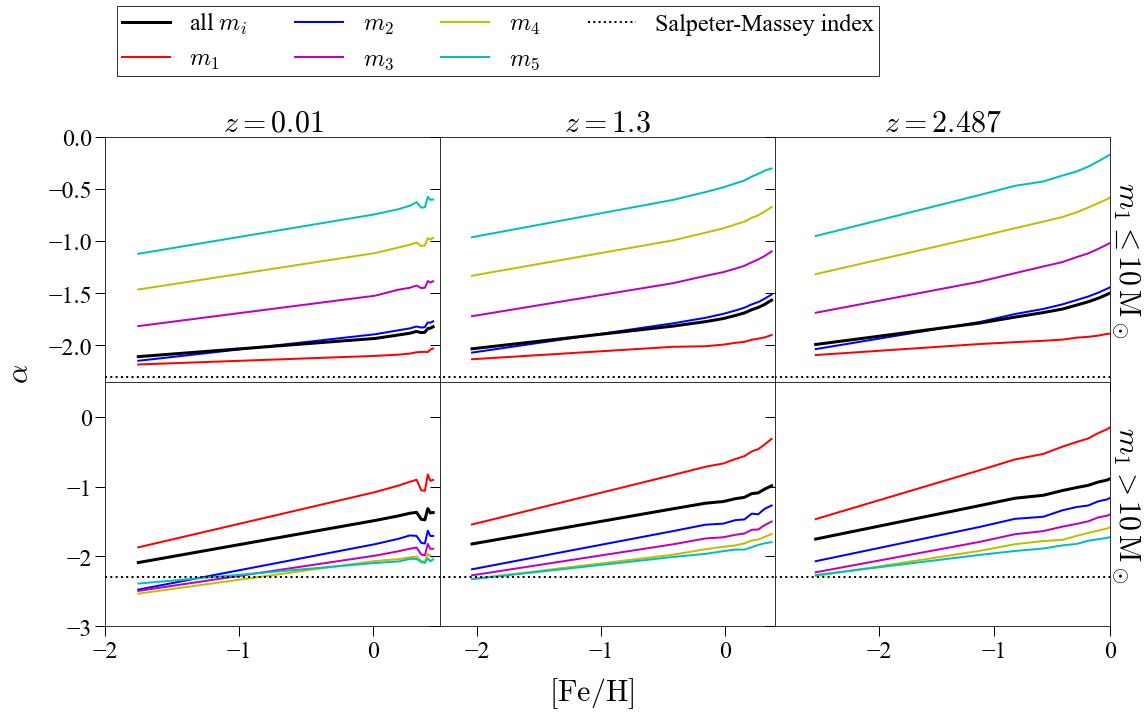

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = list(allmult_slope_dict.keys())[::4]
for z, ax in zip(plot_zs, axes[0]):
    z_dict = allmult_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,1], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,1], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,1], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1]):
    z_dict = allmult_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,2], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,2], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,2], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)


    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-2.35, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-3, 0.5)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2, 0.5)
axes[0,1].set_xlim(-2.3, 0.4)
axes[0,2].set_xlim(-2.9, 0)
    
#axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='k', lw=3, label='all $m_i$'),
           Line2D([2], [1], color='r', lw=2, label='$m_1$'),
           Line2D([2], [1], color='b', lw=2, label='$m_2$'),
           Line2D([2], [1], color='m', lw=2, label='$m_3$'),
           Line2D([2], [1], color='y', lw=2, label='$m_4$'),
           Line2D([2], [1], color='c', lw=2, label='$m_5$'),
           Line2D([2], [1], color='k', lw=2, ls=':', label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

for z, ax in zip(plot_zs, axes[0]):
    ax.text(0.5, 1, f'$z={z}$', ha='center', va='bottom', transform=ax.transAxes)

axes[0,2].text(1, 0.5, r'$m_1\leq10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[0,2].transAxes)
axes[1,2].text(1, 0.5, r'$m_1>10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[1,2].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

plt.savefig(FIGURE_FOLDER/f'imf_exponent_allmult_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_exponent_allmult_1e6.png', bbox_inches='tight')

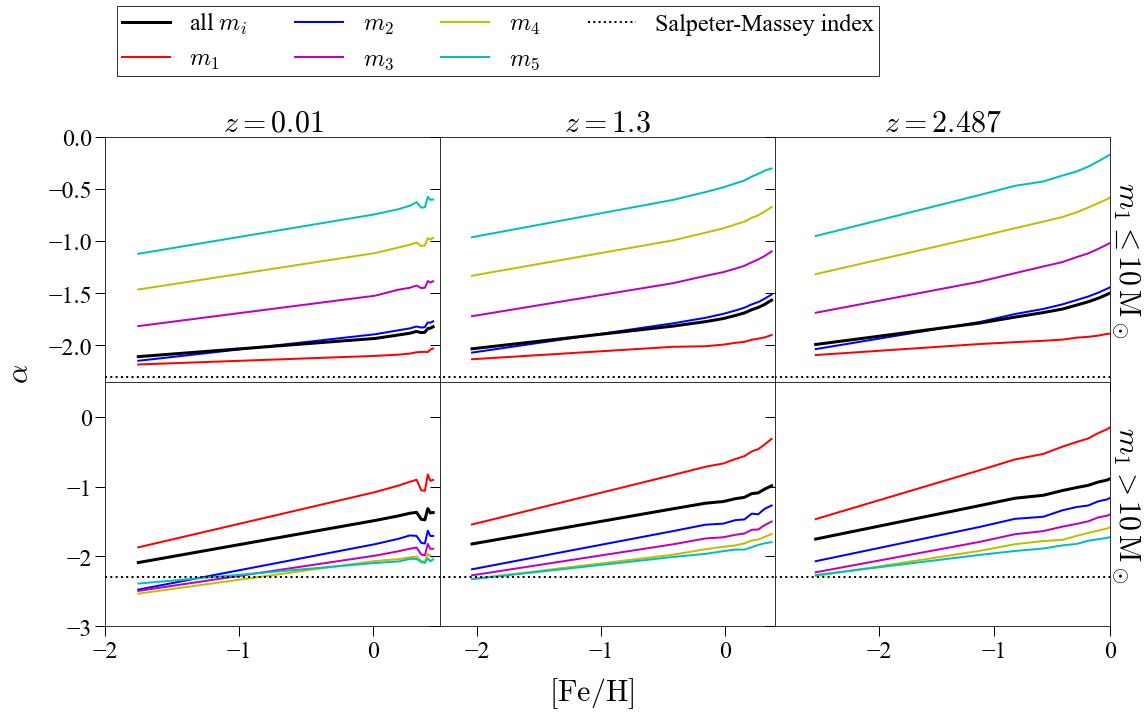

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = list(allmult_slope_dict.keys())[::4]
for z, ax in zip(plot_zs, axes[0]):
    z_dict = allmult_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,1], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,1], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,1], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1]):
    z_dict = allmult_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,2], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,2], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,2], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)

    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-2.35, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-3, 0.5)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2, 0.5)
axes[0,1].set_xlim(-2.3, 0.4)
axes[0,2].set_xlim(-2.9, 0)
    
#axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='k', lw=3, label='all $m_i$'),
           Line2D([2], [1], color='r', lw=2, label='$m_1$'),
           Line2D([2], [1], color='b', lw=2, label='$m_2$'),
           Line2D([2], [1], color='m', lw=2, label='$m_3$'),
           Line2D([2], [1], color='y', lw=2, label='$m_4$'),
           Line2D([2], [1], color='c', lw=2, label='$m_5$'),
           Line2D([2], [1], color='k', lw=2, ls=':', label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

for z, ax in zip(plot_zs, axes[0]):
    ax.text(0.5, 1, f'$z={z}$', ha='center', va='bottom', transform=ax.transAxes)

axes[0,2].text(1, 0.5, r'$m_1\leq10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[0,2].transAxes)
axes[1,2].text(1, 0.5, r'$m_1>10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[1,2].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

plt.savefig(FIGURE_FOLDER/f'imf_exponent_allmult_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_exponent_allmult_1e6.png', bbox_inches='tight')

Figure 13

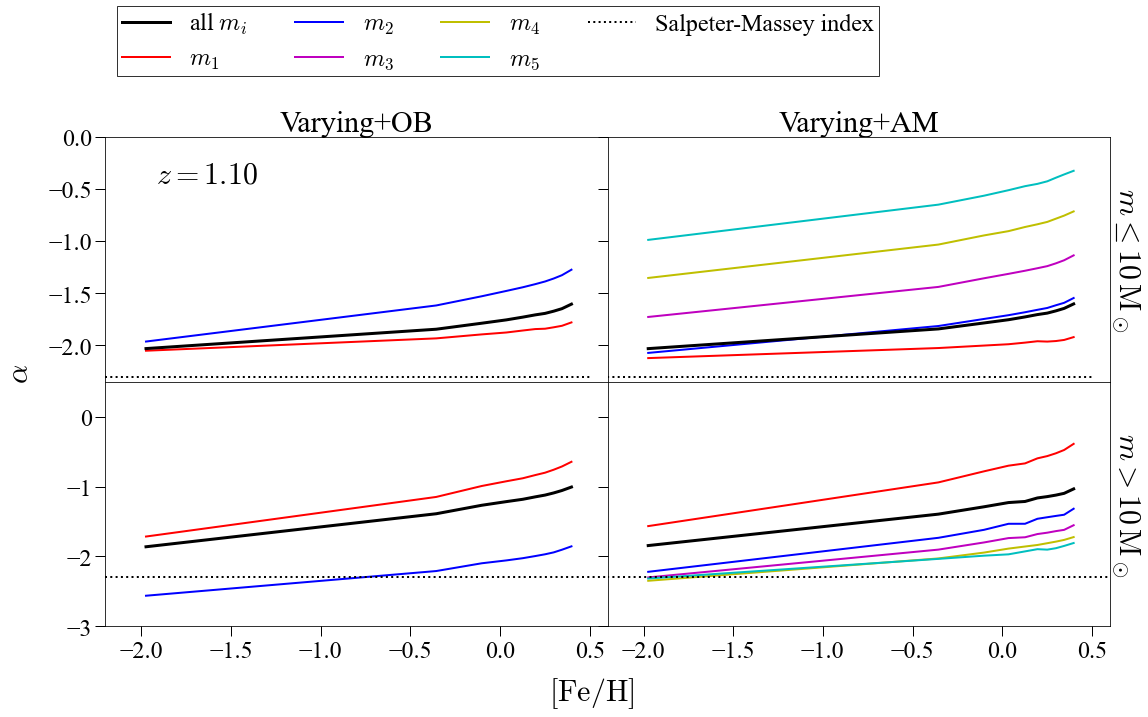

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = np.array(list(allmult_slope_dict.keys()))[[3]]
for z, ax in zip(plot_zs, axes[0,1:]):
    z_dict = allmult_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,1], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,1], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,1], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1,1:]):
    z_dict = allmult_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,2], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,2], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,2], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[0,:1]):
    z_dict = onlybin_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1,:1]):
    z_dict = onlybin_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)
    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-2.35, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-3, 0.5)
    ax.hlines(-2.3, -3, 1, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2.2, 0.6)
axes[0,1].set_xlim(-2.2, 0.6)
#axes[0,2].set_xlim(-2.9, 0)
    
#axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='k', lw=3, label='all $m_i$'),
           Line2D([2], [1], color='r', lw=2, label='$m_1$'),
           Line2D([2], [1], color='b', lw=2, label='$m_2$'),
           Line2D([2], [1], color='m', lw=2, label='$m_3$'),
           Line2D([2], [1], color='y', lw=2, label='$m_4$'),
           Line2D([2], [1], color='c', lw=2, label='$m_5$'),
           Line2D([2], [1], color='k', lw=2, ls=':', label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

axes[0,1].text(0.1, 0.9, f'$z={plot_zs[0]:.2f}$', ha='left', va='top', transform=axes[0,0].transAxes)

axes[0,1].text(1, 0.5, r'$m\leq10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[0,1].transAxes)
axes[1,1].text(1, 0.5, r'$m>10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[1,1].transAxes)

axes[0,1].text(0.5, 1, 'Varying+OB', ha='center', va='bottom', transform=axes[0,0].transAxes)
axes[0,0].text(0.5, 1, 'Varying+AM', ha='center', va='bottom', transform=axes[0,1].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

plt.savefig(FIGURE_FOLDER/f'imf_exponent_amob_comparison_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_exponent_amob_comparison_1e6.png', bbox_inches='tight')

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = list(allmult_slope_dict.keys())[::4]
for z, ax in zip(plot_zs, axes[0]):
    z_dict = allmult_canon_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,1], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,1], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,1], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'k-', lw=3)

for z, ax in zip(plot_zs, axes[1]):
    z_dict = allmult_canon_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    m3slopess = []
    m4slopess = []
    m5slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        m3slopes = z_dict[feh]['$m_3$']
        m4slopes = z_dict[feh]['$m_4$']
        m5slopes = z_dict[feh]['$m_5$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        m3slopess.append(m3slopes)
        m4slopess.append(m4slopes)
        m5slopess.append(m5slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    m3slopess = np.array(m3slopess)
    m4slopess = np.array(m4slopess)
    m5slopess = np.array(m5slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,2], 'r-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b-', lw=2)
    ax.plot(fehs, m3slopess[:,2], 'm-', lw=2)
    ax.plot(fehs, m4slopess[:,2], 'y-', lw=2)
    ax.plot(fehs, m5slopess[:,2], 'c-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'k-', lw=3)

    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    #ax.set_ylim(-2.35, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    #ax.set_ylim(-3, 0.5)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2, 0.5)
axes[0,1].set_xlim(-2.3, 0.4)
axes[0,2].set_xlim(-2.9, 0)
    
#axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='k', lw=3, label='all $m_i$'),
           Line2D([2], [1], color='r', lw=2, label='$m_1$'),
           Line2D([2], [1], color='b', lw=2, label='$m_2$'),
           Line2D([2], [1], color='m', lw=2, label='$m_3$'),
           Line2D([2], [1], color='y', lw=2, label='$m_4$'),
           Line2D([2], [1], color='c', lw=2, label='$m_5$'),
           Line2D([2], [1], color='k', lw=2, ls=':', label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

for z, ax in zip(plot_zs, axes[0]):
    ax.text(0.5, 1, f'$z={z}$', ha='center', va='bottom', transform=ax.transAxes)

axes[0,2].text(1, 0.5, r'$m_1\leq10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[0,2].transAxes)
axes[1,2].text(1, 0.5, r'$m_1>10\,\mathrm{M}_\odot$', rotation=-90, ha='left', va='center', transform=axes[1,2].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

plt.savefig(FIGURE_FOLDER/f'imf_exponent_canon_allmult_1e6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_exponent_canon_allmult_1e6.png', bbox_inches='tight')are never repeated, so for the plot we collect

SyntaxError: invalid syntax (316154512.py, line 123)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18,9), sharey='row', sharex='col')
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

plot_zs = list(onlybin_slope_dict.keys())[::4]
for z, ax in zip(plot_zs, axes[0]):
    z_dict = onlybin_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,1], 'r-', lw=2)
    ax.plot(fehs, m1slopess[:,2], 'r--', lw=2)
    ax.plot(fehs, m2slopess[:,1], 'b-', lw=2)
    ax.plot(fehs, m2slopess[:,2], 'b--', lw=2)
    ax.plot(fehs, mallslopess[:,1], 'g-', lw=2)
    ax.plot(fehs, mallslopess[:,2], 'g--', lw=2)
    
for z, ax in zip(plot_zs, axes[1]):
    z_dict = onlybin_canon_slope_dict[z]
    
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)

    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)

    ax.plot(fehs, m1slopess[:,0], 'r:', lw=2)
    ax.plot(fehs, m2slopess[:,0], 'b:', lw=2)
    ax.plot(fehs, mallslopess[:,0], 'g:', lw=2)
    
for ax in axes[0]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-2.7, 0)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    ax.set_yticks(np.arange(-2.5, 0, 0.5))
    
for ax in axes[1]:
    #ax.set_xlim(-3, 0.7)
    ax.set_ylim(-3, -1.9)
    ax.hlines(-2.3, -3, 0.5, color='k', ls=':', lw=2)
    #ax.set_yticks(np.arange(-2.5, 0, 0.5))

axes[0,0].set_xlim(-2, 0.5)
axes[0,1].set_xlim(-2.3, 0.4)
axes[0,2].set_xlim(-2.9, 0)
    
axes[0,0].set_yticks(np.arange(-2.5, 0.5, 0.5))
handles = [Line2D([2], [1], color='g', label='all $m_i$'),
           Line2D([2], [1], color='r', label='$m_1$'),
           Line2D([2], [1], color='b', label='$m_2$'),
           Line2D([2], [1], color='k', ls='-', lw=2, label='$m\leq10\,\mathrm{M}_\odot$'),
           Line2D([2], [1], color='k', ls='--', lw=2, label='$m>10\,\mathrm{M}_\odot$'),
           Line2D([2], [1], color='k', ls=':', lw=2, label='Salpeter-Massey index')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.2), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=24)

for z, ax in zip(plot_zs, axes[0]):
    ax.text(0.5, 1, f'$z={z}$', ha='center', va='bottom', transform=ax.transAxes)

axes[0,2].text(1, 0.5, 'Varying', rotation=-90, ha='left', va='center', transform=axes[0,2].transAxes)
axes[1,2].text(1, 0.5, 'Universal', rotation=-90, ha='left', va='center', transform=axes[1,2].transAxes)
    

fig.text(0.5, 0.05, '$\mathrm{[Fe/H]}$',va='top', ha='center')
fig.text(0.07, 0.5, '$\\alpha$', rotation=90, va='bottom', ha='right')

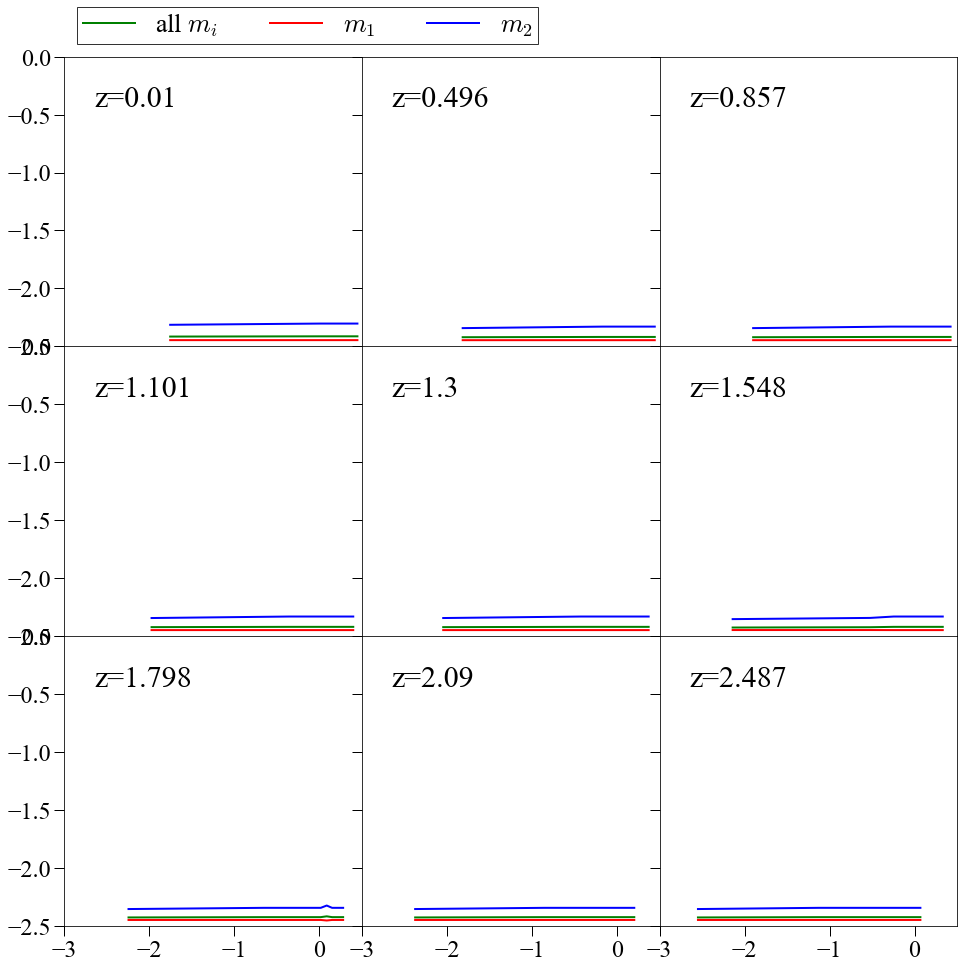

In [102]:
fig, axes = plt.subplots(3, 3, figsize=(16,16), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

for z, ax in zip(slope_dict, axes.flatten()):
    z_dict = slope_dict[z]
    fehs = []
    m1slopess = []
    m2slopess = []
    mallslopess = []
    for feh in z_dict:
        m1slopes = z_dict[feh]['$m_1$']
        m2slopes = z_dict[feh]['$m_2$']
        mallslopes = z_dict[feh]['all $m_i$']
        fehs.append(feh)
        m1slopess.append(m1slopes)
        m2slopess.append(m2slopes)
        mallslopess.append(mallslopes)
    m1slopess = np.array(m1slopess)
    m2slopess = np.array(m2slopess)
    mallslopess = np.array(mallslopess)
    
    ax.plot(fehs, m1slopess[:,0], 'g-')
    ax.plot(fehs, m1slopess[:,1], 'r-')
    ax.plot(fehs, m1slopess[:,2], 'b-')
    ax.text(0.1, 0.9, f'{z=}', ha='left', va='top', transform=ax.transAxes)
    
for ax in axes.flatten():
    ax.set_xlim(-3, 0.5)
    ax.set_ylim(-2.5, 0)

handles = [Line2D([2], [1], color='g', label='all $m_i$'),
           Line2D([2], [1], color='r', label='$m_1$'),
           Line2D([2], [1], color='b', label='$m_2$')]
axes[0,0].legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2)

IndexError: list index out of range

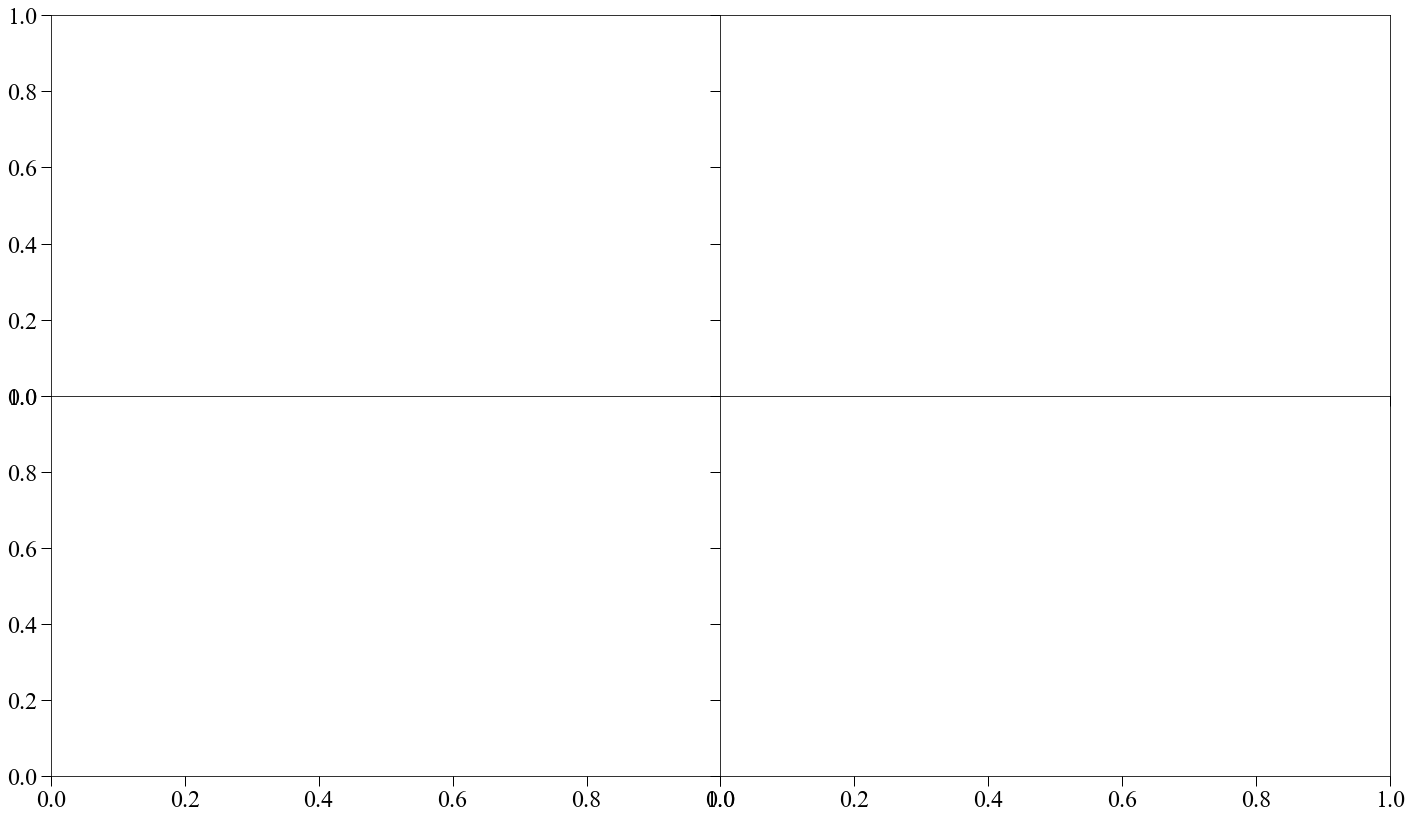

In [70]:
fig, axes_ = plt.subplots(2, 2, figsize=(24, 14), sharex=True, sharey=True)
axes = axes_#.flatten()
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

z = plot_zs[3]

######### Q CORR ONLYBIN PLOT ###############
sample_paths_ = onlybin_sample_paths_dict[z]
ax = axes[1,0]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    corr_onlybin_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[0,1,-1], c=None, title=False)
    counter += 1

ax.set_xlim(0.8, 150)
ax.set_ylim(1e-5, 2e0)

######### Q NOCORR ONLYBIN PLOT ###############
sample_paths_ = onlybin_canon_sample_paths_dict[z]
ax = axes[0,0]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    nocorr_onlybin_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=True, mindex=[0,1,-1], c=None, title=False)
    counter += 1

ax.set_xlim(0.8, 150)
ax.set_ylim(1e-5, 2e0)

#################### Q CORR ALLMULT PLOT ################
sample_paths_ = allmult_sample_paths_dict[z]   
ax = axes[1,1]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    #c = cm.viridis(counter/9)
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    corr_allmult_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=False, mindex=[0,1,2,3,4,-1], c=None, title=False)
    counter += 1

ax.set_xlim(0.8, 150)
ax.set_ylim(1e-5, 2e0)

#################### Q NOCORR ALLMULT PLOT ################
sample_paths_ = allmult_canon_sample_paths_dict[z]   
ax = axes[0,1]

for b in np.logspace(-5, 5, 10):
    ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
    #ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
    ax.plot(ms, [0.5*b*kroupa_imf(m) for m in ms], 'k--', lw=1, alpha=0.5)

counter = 0
for path in sample_paths_[[5]]:
    sample_descr = path.name.split('_')[:-3]

    sample_descr_dict = {}
    for attr in sample_descr:
        key, value = attr.split('=')
        sample_descr_dict[key] = value

    feh = np.float32(sample_descr_dict['feh'])
    #c = cm.viridis(counter/9)
    c = cm.viridis((feh-min_plot_feh)/norm_plot_feh)

    sample_df = pd.read_parquet(path, engine='pyarrow')

    legend = False
    if counter == 0:
        legend = True

    nocorr_allmult_mplots = plot_imf(ax, sample_df, sample_descr_dict, bins=np.logspace(np.log10(0.8), np.log10(150), 50), legend=False, kroupa=True, mindex=[0,1,2,3,4,-1], c=None, title=False)
    counter += 1

z_descr_str = '\n'.join([f'$z_\mathrm{{ZAMS}}={z:.2f}$',
                         f'$\mathrm{{[Fe/H]}}={feh:.2f}$'])
z_descr = ax.text(0.95, 0.95, z_descr_str, ha='right', va='top', transform=ax.transAxes, fontsize=30)
z_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))

############ FINAL DETAILS #############

for ax in axes.flatten():
    ax.set_xlim(0.8, 150)
    ax.set_ylim(7e-6, 2e0)
    ax.tick_params(labelsize=30)
    
fig.text(0.5, 1, 'Only binaries', ha='center', va='bottom', transform=axes[0,0].transAxes, fontsize=36)
fig.text(0.5, 1, 'All multiples', ha='center', va='bottom', transform=axes[0,1].transAxes, fontsize=36)
fig.text(1.02, 0.5, 'IGIMF', ha='left', va='center', rotation=-90, transform=axes[1,1].transAxes, fontsize=36)
fig.text(1.02, 0.5, 'Kroupa', ha='left', va='center', rotation=-90, transform=axes[0,1].transAxes, fontsize=36)

fig.text(0.07, 0.5, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},\mathrm{SFR}\right)/(\mathrm{M}_\odot^{-1})\right]$', 
         ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=36)
fig.text(0.5, 0.05, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top', fontsize=36)

mplots = [['r', '--', r'$m_1$'],
         ['b', '--', r'$m_2$'],
         ['m', '--', r'$m_3$'],
         ['y', '--', r'$m_4$'],
         ['c', '--', r'$m_5$'],
         ['g', '-', r'all $m_i$']]

for ax in [axes[0,0]]:
    handles = []
    for mplot in mplots:
        sample_line = Line2D([0], [0], label=mplot[2], color=mplot[0], linestyle=mplot[1])
        handles.append(sample_line)
    igimf_line = Line2D([0], [0], label='IGIMF', color='k',  linestyle='-')
    kroupa_line = Line2D([0], [0], label='Kroupa', color='k', linestyle='--')
    handles += [kroupa_line, igimf_line]
    ax.legend(handles=handles, frameon=True, loc='lower left', bbox_to_anchor=(0,1.1), ncol=4, edgecolor='black', fancybox=False, borderpad=0.2)
    
plt.savefig(FIGURE_FOLDER/f'imf_sampling_comparison_1e4.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/f'imf_sampling_comparison_1e4.png', bbox_inches='tight')

In [71]:
samples_mplots = {'corr_onlybin': corr_onlybin_mplots, 
                  'nocorr_onlybin': nocorr_onlybin_mplots,
                  'corr_allmult': corr_allmult_mplots,
                  'nocorr_allmult': nocorr_allmult_mplots}
mplot_array_labels = ['m1', 'm2', 'm3', 'm4', 'm5', 'm21', 'mall']

for sample_label in samples_mplots:pact object mergers. Released in 2019, the first Gravitational Wavepact object mergers. Released in 2019, the first Gravitational Wave
    mplots = samples_mplots[sample_label]
    for mplot, mplot_label in zip(mplots, mplot_array_labels):
        mc, mh, color, ls, lw, label = mplot
        mc = np.log10(mc)
        mh = np.log10(mh)
        mc10_i = np.searchsorted(mc, 1)
        slope, *_ = linregress(mc, mh)
        slope1, *_ = linregress(mc[:mc10_i], mh[:mc10_i])
        slope2, *_ = linregress(mc[mc10_i:], mh[mc10_i:])
        print(f'In {sample_label} label, {mplot_label} is best fit by a power-law {slope:.2f}, or {slope1:.2f} up to {10**mc[mc10_i]:.2f} Mo and {slope2:.2f} above.')
    print('')

NameError: name 'corr_onlybin_mplots' is not defined

In [ ]:
pact object mergers. Released in 2019, the first Gravitational Wave